Created to simulate a tandem of two single-service queue system.

Adapted from [Willie Wheeler's single-queue network simulation](https://medium.com/wwblog/simulating-an-m-m-1-queue-in-python-f894f5a68db2).

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

In [2]:
# Constants, etc.
rng = np.random.default_rng(34)

# Queue structure

The system is an open queue system.

Arrival -> =====](Q1) -> =====](Q2) -> Departure

## Arrival
Arrival time is uniform, interarrival time has boundaries of [1, 5] (mean time of 3s)

## Queue Q1
Service time is exponential, service rate m1 = 0.5/s (mean time of 2s)

## Queue Q2
Service time is uniform, with boundaries of [1, 3] (mean time of 2s)

# Simulation

Basically just creating arrival times and service times according to the given distributions.

In [3]:
def create_params(num_customers: int, mean_interarrival_time: float, mean_interarrival_range: float, mean_service_time_1: float, mean_service_time_2: float, mean_service_time_2_range: float):
    return {
        "n": num_customers,
        "mean_interarrival_time": mean_interarrival_time,
        "mean_interarrival_low": mean_interarrival_time - mean_interarrival_range/2,
        "mean_interarrival_high": mean_interarrival_time + mean_interarrival_range/2,
        "mean_service_time_1": mean_service_time_1,
        "mean_service_time_2": mean_service_time_2,
        "mean_service_time_2_low": mean_service_time_2 - mean_service_time_2_range/2,
        "mean_service_time_2_high": mean_service_time_2 + mean_service_time_2_range/2,
        "mean_arrival_rate": 1.0 / mean_interarrival_time,
        "mean_service_rate_1": 1.0 / mean_service_time_1,
        "mean_service_rate_2": 1.0 / mean_service_time_2,
        "num_bins": int(num_customers * mean_interarrival_time)
    }

In [4]:
def build_customers_dataframe(params, interarrival_times, arrival_times, service_1_times, service_2_times):
    n = params["n"]

    customers_df = pd.DataFrame({
        "interarrival_time": interarrival_times,
        "arrival_time": arrival_times, # When the customer arrives in the system
        "service_time_1": service_1_times, # How long the customer is serviced in service 1
        "service_time_2": service_2_times, # How long the customer is serviced in service 2
        "start_time_1": np.zeros(n), # When the customer starts being serviced in service 1
        "depart_time_1": np.zeros(n), # When the customer is done being serviced by service 1
        "start_time_2": np.zeros(n), # When the customer starts being serviced in service 2
        "depart_time_2": np.zeros(n), # When the customer departs from the system (aka done being serviced by service 2)
        "response_time": np.zeros(n), # How long the customer spends within the system
        "wait_time_1": np.zeros(n), # How long the customer waits in queue 1
        "wait_time_2": np.zeros(n), # How long the customer waits in queue 2
    })

    # The first customer is the easiest to document
    customers_df.loc[0, "start_time_1"] = customers_df.loc[0, "arrival_time"]
    customers_df.loc[0, "depart_time_1"] = customers_df.loc[0, "start_time_1"] + customers_df.loc[0, "service_time_1"]
    customers_df.loc[0, "start_time_2"] = customers_df.loc[0, "depart_time_1"]
    customers_df.loc[0, "depart_time_2"] = customers_df.loc[0, "start_time_2"] + customers_df.loc[0, "service_time_2"]

    # Each customer has to wait for the previous customer(s) to finish their stuff first
    for i in range(1, n):
        # Customer i can only start when customer i-1 is done with the service at hand
        customers_df.loc[i, "start_time_1"] = max(customers_df.loc[i, "arrival_time"], customers_df.loc[i-1, "depart_time_1"])
        customers_df.loc[i, "depart_time_1"] = customers_df.loc[i, "start_time_1"] + customers_df.loc[i, "service_time_1"]
        customers_df.loc[i, "start_time_2"] = max(customers_df.loc[i, "depart_time_1"], customers_df.loc[i-1, "depart_time_2"])
        customers_df.loc[i, "depart_time_2"] = customers_df.loc[i, "start_time_2"] + customers_df.loc[i, "service_time_2"]

    customers_df["response_time"] = customers_df["depart_time_2"] - customers_df["arrival_time"]
    customers_df["wait_time_1"] = customers_df["start_time_1"] - customers_df["arrival_time"]
    customers_df["wait_time_2"] = customers_df["start_time_2"] - customers_df["depart_time_1"]

    return customers_df    

In [5]:
def run_simulation(params):
    # Extracting parameters
    n = params["n"]
    iat = params["mean_interarrival_time"]
    ial = params["mean_interarrival_low"]
    iah = params["mean_interarrival_high"]
    st1 = params["mean_service_time_1"]
    st2 = params["mean_service_time_2"]
    st2l = params["mean_service_time_2_low"]
    st2h = params["mean_service_time_2_high"]

    # Sim data
    interarrival_times = rng.uniform(low=ial, high=iah, size=n)
    arrival_times = np.cumsum(interarrival_times)
    service_1_times = rng.exponential(scale=st1, size=n)
    service_2_times = rng.uniform(low=st2l, high= st2h, size=n)

    customers_df = build_customers_dataframe(params, interarrival_times, arrival_times, service_1_times, service_2_times)

    return customers_df

# Testing code

Checking whether or not the simulation works.

In [6]:
customers = 500

params = create_params(customers, 3, 4, 2, 2, 2)

final = run_simulation(params)

final

,interarrival_time,arrival_time,service_time_1,service_time_2,start_time_1,depart_time_1,start_time_2,depart_time_2,response_time,wait_time_1,wait_time_2
0,1.016113,1.016113,1.296557,2.882981,1.016113,2.312670,2.312670,5.195652,4.179539,0.000000,0.000000
1,4.488708,5.504821,1.409844,2.387604,5.504821,6.914664,6.914664,9.302268,3.797448,0.000000,0.000000
2,1.970970,7.475790,1.907014,1.307079,7.475790,9.382804,9.382804,10.689883,3.214093,0.000000,0.000000
3,3.604245,11.080035,1.674852,2.150709,11.080035,12.754887,12.754887,14.905597,3.825561,0.000000,0.000000
4,2.936370,14.016405,0.385494,2.080945,14.016405,14.401899,14.905597,16.986541,2.970137,0.000000,0.503697
...,...,...,...,...,...,...,...,...,...,...,...
495,2.546238,1494.158906,1.647598,1.738314,1494.158906,1495.806504,1497.468775,1499.207089,5.048183,0.000000,1.662272
496,4.926428,1499.085333,3.141192,1.049107,1499.085333,1502.226526,1502.226526,1503.275632,4.190299,0.000000,0.000000
497,3.252912,1502.338246,3.080289,2.630679,1502.338246,1505.418535,1505.418535,1508.049214,5.710968,0.000000,0.000000
498,1.527312,1503.865558,0.397625,2.464443,1505.418535,1505.816160,1508.049214,1510.513657,6.648099,1.552977,2.233054


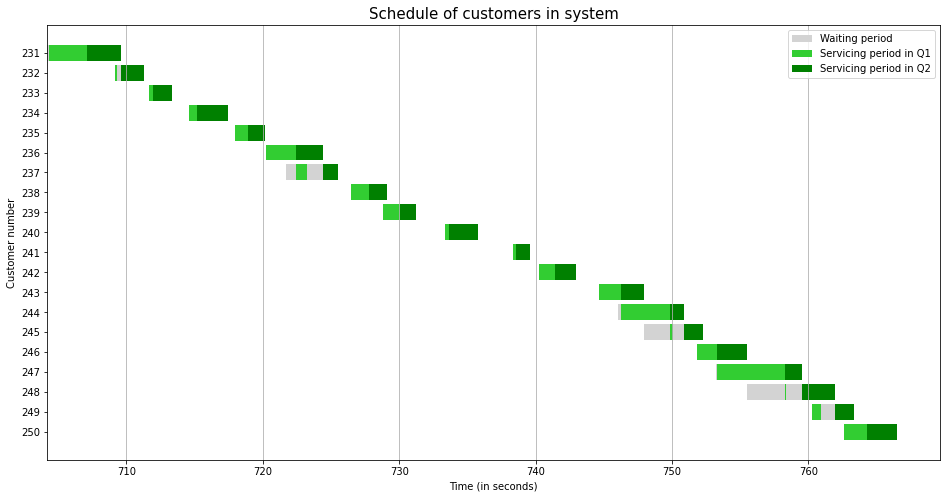

In [7]:
# The hard part: Plotting this so it looks good
# Okay I know this isn't strictly needed for the homework but I just really like how Gantt Charts look
cut = final[231:251]

plt.figure(figsize=(16,8))
plt.title("Schedule of customers in system", size=15)
plt.xlabel("Time (in seconds)")
plt.ylabel("Customer number")
plt.yticks(np.arange(min(cut.index), max(cut.index)+1, 1.0))
legend_elements = [Patch(facecolor="lightgray",label='Waiting period'), Patch(facecolor="limegreen",label='Servicing period in Q1'), Patch(facecolor="green",label='Servicing period in Q2')]
plt.barh(
    y = cut.index,
    left = cut["arrival_time"],
    width = cut["response_time"],
    alpha = 1.0,
    color = "lightgray"
)
plt.barh(
    y = cut.index,
    left = cut["start_time_1"],
    width = cut["service_time_1"],
    alpha = 1.0,
    color = "limegreen"
)
plt.barh(
    y = cut.index,
    left = cut["start_time_2"],
    width = cut["service_time_2"],
    alpha = 1.0,
    color = "green"
)
plt.legend(handles=legend_elements)
plt.gca().invert_yaxis()
plt.grid(axis="x")
plt.show()

# Getting data and stuff

In [20]:
def get_measures(customers_df: pd.DataFrame):
    return {
        "mean_response_time": customers_df["response_time"].mean(),
        "std_response_time": customers_df["response_time"].std(),
        "mean_wait_time_1": customers_df["wait_time_1"].mean(),
        "std_wait_time_1": customers_df["wait_time_1"].std(),
        "mean_wait_time_2": customers_df["wait_time_2"].mean(),
        "std_wait_time_2": customers_df["wait_time_2"].std()
    }

def display_measures(customers_df: pd.DataFrame):
    measures = get_measures(customers_df)

    print('''
Response time (T):
    mean = %.3f seconds,
    standard deviation = %.3f seconds

Wait time in the queue of Q1 (Tq1):
    mean = %.3f seconds,
    standard deviation = %.3f seconds

Wait time in the queue of Q1 (Tq1):
    mean = %.3f seconds,
    standard deviation = %.3f seconds
''' % (measures["mean_response_time"], measures["std_response_time"], measures["mean_wait_time_1"], measures["std_wait_time_1"], measures["mean_wait_time_2"], measures["std_wait_time_2"]))

In [39]:
scenario1 = run_simulation(create_params(500, 3, 4, 2, 2, 2))

display_measures(scenario1)

[6.11597262076753, 2.9036871112456843, 1.1519869564641094, 2.1155307307702076, 1.0509745422814838, 1.3755755573619006]

Response time (T):
    mean = 6.116 seconds,
    standard deviation = 2.904 seconds

Wait time in the queue of Q1 (Tq1):
    mean = 1.152 seconds,
    standard deviation = 2.116 seconds

Wait time in the queue of Q1 (Tq1):
    mean = 1.051 seconds,
    standard deviation = 1.376 seconds



In [24]:
scenario2 = run_simulation(create_params(1000, 3, 4, 2, 2, 2))

display_measures(scenario2)


Response time (T):
    mean = 7.393 seconds,
    standard deviation = 4.335 seconds

Wait time in the queue of Q1 (Tq1):
    mean = 1.944 seconds,
    standard deviation = 3.289 seconds

Wait time in the queue of Q1 (Tq1):
    mean = 1.441 seconds,
    standard deviation = 2.120 seconds



In [25]:
scenario3 = run_simulation(create_params(500, 3, 4, 2, 2, 2))

display_measures(scenario3)


Response time (T):
    mean = 6.617 seconds,
    standard deviation = 3.675 seconds

Wait time in the queue of Q1 (Tq1):
    mean = 1.469 seconds,
    standard deviation = 2.779 seconds

Wait time in the queue of Q1 (Tq1):
    mean = 1.152 seconds,
    standard deviation = 1.635 seconds



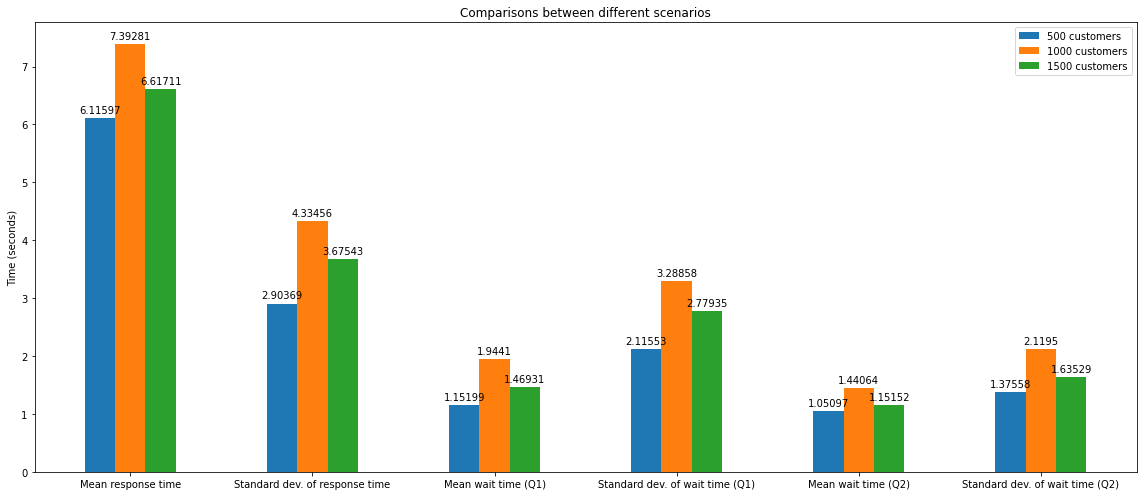

In [54]:
labels = ['Mean response time', 'Standard dev. of response time', 'Mean wait time (Q1)', 'Standard dev. of wait time (Q1)' , 'Mean wait time (Q2)', 'Standard dev. of wait time (Q2)']
scenario1_measures = list(get_measures(scenario1).values())
scenario2_measures = list(get_measures(scenario2).values())
scenario3_measures = list(get_measures(scenario3).values())

x = np.arange(len(labels))  # the label locations
width = 0.5  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/3, scenario1_measures, width/3, label='500 customers')
rects2 = ax.bar(x, scenario2_measures, width/3, label='1000 customers')
rects3 = ax.bar(x + width/3, scenario3_measures, width/3, label='1500 customers')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Time (seconds)')
ax.set_title('Comparisons between different scenarios')
ax.set_xticks(x, labels)
fig.set_size_inches(16,7)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
ax.bar_label(rects3, padding=3)

fig.tight_layout()

plt.show()

In [58]:
# I don't know
mean_response_times_500 = []
mean_response_times_1000 = []
mean_response_times_1500 = []

for i in range(0, 10):
    mean_response_times_500.append(get_measures(run_simulation(create_params(500, 3, 4, 2, 2, 2)))["mean_response_time"])
    mean_response_times_1000.append(get_measures(run_simulation(create_params(1000, 3, 4, 2, 2, 2)))["mean_response_time"])
    mean_response_times_1500.append(get_measures(run_simulation(create_params(1500, 3, 4, 2, 2, 2)))["mean_response_time"])

print(mean_response_times_500, mean_response_times_1000, mean_response_times_1500)

[6.592281722770928, 7.10359613481421, 6.934354968495101, 6.8208092638788855, 6.865003187614376, 7.938655746113232, 6.332665559161784, 7.038729017276799, 7.671859328667486, 6.720703924180143] [6.723737553116196, 6.523923646135383, 6.159569509860725, 6.8196494027563865, 9.319701368773565, 6.289981456956206, 6.149215408090212, 9.087715759357357, 6.727635198263627, 7.603978991687701] [7.048918924692644, 7.21509063116322, 7.293675989768418, 7.441447365835952, 6.813761743308654, 6.971289351078439, 6.773310105550462, 6.337980801863717, 6.930535305814333, 7.068607103215725]


In [62]:
print('''
Skenario dengan banyak customer 500:
 E[T] = %.5f detik

Skenario dengan banyak customer 1000:
 E[T] = %.5f detik

Skenario dengan banyak customer 1500:
 E[T] = %.5f detik
''' % (np.average(mean_response_times_500), np.average(mean_response_times_1000), np.average(mean_response_times_1500)))


Skenario dengan banyak customer 500:
 E[T] = 7.00187 detik

Skenario dengan banyak customer 1000:
 E[T] = 7.14051 detik

Skenario dengan banyak customer 1500:
 E[T] = 6.98946 detik

